# Setup: Generate Sample Dataset

This cell creates the required folder structure (`data/raw/` and `data/processed/`) relative to the notebook, and generates the sample CSV dataset with missing values. 
This ensures the dataset is ready for cleaning functions and saves it to `data/raw/outliers_homework.csv`.

In [1]:
# import os
# import numpy as np
# import pandas as pd

# # Define folder paths relative to this notebook
# raw_dir = '../data/raw'
# processed_dir = '../data/processed'

# # Create folders if they don't exist
# os.makedirs(raw_dir, exist_ok=True)
# os.makedirs(processed_dir, exist_ok=True)

# # Generate business day dates
# dates = pd.date_range(start="2022-01-03", end="2022-06-10", freq="B")

# # Fixed random seed for reproducibility
# np.random.seed(17)

# # Column 1: daily_return ~ N(0, 0.01)
# returns = np.random.normal(0, 0.01, size=len(dates))
# mask_pre_may = dates < "2022-05-01"
# returns[mask_pre_may] -= 0.0015  

# # Inject "shock" values
# shock_values = {
#     "2022-05-02": 0.1748425237194541,
#     "2022-05-03": -0.16825801732486943,
#     "2022-05-06": -0.19667220757153227,
#     "2022-05-09": 0.21240223590614747,
#     "2022-05-12": -0.178729287231294
# }
# for d, v in shock_values.items():
#     idx = np.where(dates == pd.to_datetime(d))[0][0]
#     returns[idx] = v

# # Column 2: daily_return_2, correlated with daily_return + small noise
# daily_return_2 = returns * 0.6 + np.random.normal(0, 0.005, size=len(dates))

# # Create DataFrame with two numeric columns
# df = pd.DataFrame({
#     "date": dates,
#     "daily_return": returns,
#     "daily_return_2": daily_return_2
# })

# # Save to CSV in raw data folder
# csv_path = os.path.join(raw_dir, 'outliers_homework.csv')
# if not os.path.exists(csv_path):
#     df.to_csv(csv_path, index=False)
#     print(f'Synthetic dataset with two columns created and saved to {csv_path}')
# else:
#     print(f'File already exists at {csv_path}. Skipping CSV creation to avoid overwrite.')

# Stage 7 Homework — Outliers + Risk Assumptions
In this assignment you will implement outlier detection/handling and run a simple sensitivity analysis.

**Chain:** In the lecture, we learned detection (IQR, Z-score), options for handling (remove/winsorize), and sensitivity testing. Now, you will adapt those methods to a provided dataset and document the risks and assumptions behind your choices.

In [2]:
# Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
np.random.seed(17)

## Load Data (provided or synthetic fallback)

In [3]:
data_path = Path('C:/User/Aislay/bootcamp_Ziyi_Yang/homework/stage07_outliers-risk-assumptions/data/raw/outliers_homework.csv')
if data_path.exists():
    df = pd.read_csv(data_path)
else:
    # Synthetic fallback: linear trend with noise and a few extremes
    x = np.linspace(0, 10, 200)
    y = 2.2 * x + 1 + np.random.normal(0, 1.2, size=x.size)
    y[10] += 15; y[120] -= 13; y[160] += 18
    df = pd.DataFrame({'x': x, 'y': y})
df.head()

,x,y
0,0.000000,1.331519
1,0.050251,-1.115001
2,0.100503,1.969787
3,0.150754,2.706032
4,0.201005,2.686840


## TODO: Implement Outlier Functions (required)

### Improve the IQR detection function

In [4]:
def detect_outliers_iqr(series: pd.Series, k: float = 0.5) -> pd.Series:
    """Return boolean mask for IQR-based outliers.
    
    Parameters:
    series: pandas Series containing numeric data
    k: multiplier for IQR (default 1.5, higher values are more conservative)
    
    Returns:
    Boolean Series where True indicates an outlier
    
    Assumptions: distribution reasonably summarized by quartiles; k controls strictness.
    """
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return (series < lower) | (series > upper)

### Improve the Z-score detection function:

In [5]:
def detect_outliers_zscore(series: pd.Series, threshold: float = 1.0) -> pd.Series:
    """Return boolean mask for Z-score outliers where |z| > threshold.
    
    Parameters:
    series: pandas Series containing numeric data
    threshold: z-score threshold (default 3.0, higher values are more conservative)
    
    Returns:
    Boolean Series where True indicates an outlier
    
    Assumptions: roughly normal distribution; sensitive to heavy tails.
    """
    mu = series.mean()
    sigma = series.std(ddof=0)
    z = (series - mu) / (sigma if sigma != 0 else 1.0)
    return z.abs() > threshold

### Implement the Winsorizing function:

In [6]:
def winsorize_series(series: pd.Series, lower: float = 0.05, upper: float = 0.95) -> pd.Series:
    """Winsorize a series by clipping values at specified quantiles.
    
    Parameters:
    series: pandas Series to winsorize
    lower: lower quantile (default 0.05)
    upper: upper quantile (default 0.95)
    
    Returns:
    Winsorized Series
    """
    lo = series.quantile(lower)
    hi = series.quantile(upper)
    return series.clip(lower=lo, upper=hi)

## Apply Detection and Create Flags (choose a numeric column)

In [7]:
# Select the first numerical column as the target
target_col = df.select_dtypes(include=['number']).columns[1]
print(f"Selected target column: {target_col}")

# Apply detection methods
df['outlier_iqr'] = detect_outliers_iqr(df[target_col])
df['outlier_z'] = detect_outliers_zscore(df[target_col], threshold=3.0)

# View the proportion marked as outliers
outlier_stats = pd.DataFrame({
    'IQR_outliers': df['outlier_iqr'].mean(),
    'Z_score_outliers': df['outlier_z'].mean()
}, index=['Fraction'])
print(outlier_stats)

Selected target column: y
          IQR_outliers  Z_score_outliers
Fraction         0.035             0.005


### Visual Checks (boxplot / histogram)

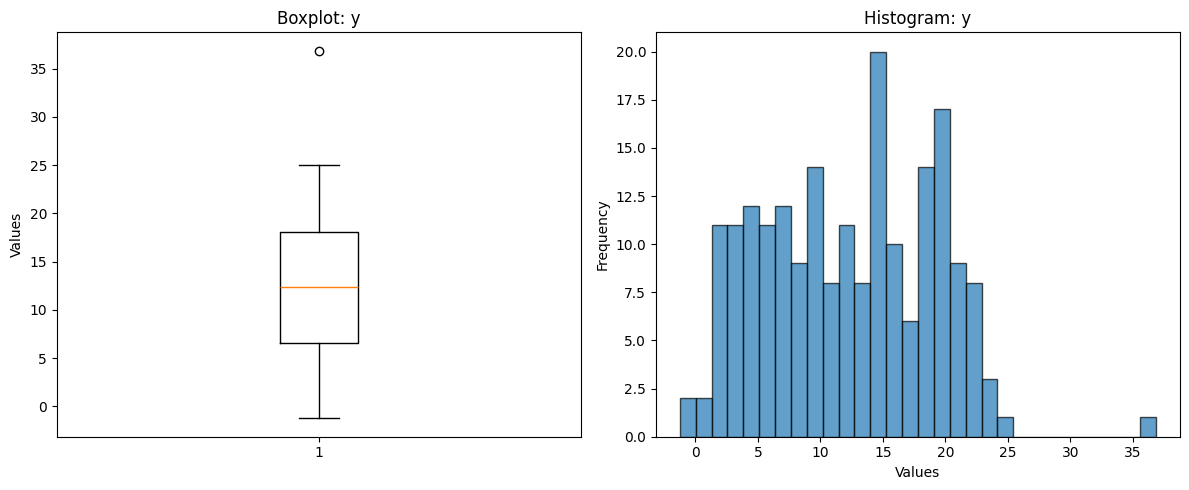

In [8]:
# Create Subgraphs
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Box Plot
ax1.boxplot(df[target_col].dropna())
ax1.set_title(f'Boxplot: {target_col}')
ax1.set_ylabel('Values')

# Histogram
ax2.hist(df[target_col].dropna(), bins=30, alpha=0.7, edgecolor='black')
ax2.set_title(f'Histogram: {target_col}')
ax2.set_xlabel('Values')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## Sensitivity Analysis
Pick one: summary stats or simple linear regression comparing **all vs. filtered** (and optional winsorized).

### Execution summary statistical comparison and Regression analysis: 

In [9]:
# Calculate the summary statistics of various processing methods
print("Summary Statistics Comparison:")

# Original Data
summ_all = df[target_col].describe()[['mean', '50%', 'std']].rename({'50%': 'median'})

# Filter out IQR outliers
if df['outlier_iqr'].sum() > 0:
    summ_filtered_iqr = df.loc[~df['outlier_iqr'], target_col].describe()[['mean', '50%', 'std']].rename({'50%': 'median'})
else:
    summ_filtered_iqr = summ_all

# Filter out Z-score outliers
if df['outlier_z'].sum() > 0:
    summ_filtered_z = df.loc[~df['outlier_z'], target_col].describe()[['mean', '50%', 'std']].rename({'50%': 'median'})
else:
    summ_filtered_z = summ_all

# If there is a winsorize function, calculate the winsorized version
if 'winsorize_series' in globals():
    w_series = winsorize_series(df[target_col])
    summ_winsorized = w_series.describe()[['mean', '50%', 'std']].rename({'50%': 'median'})

# Create a comparison table
comp_data = {
    'all_data': summ_all,
    'filtered_iqr': summ_filtered_iqr,
    'filtered_z': summ_filtered_z
}

if 'winsorize_series' in globals():
    comp_data['winsorized'] = summ_winsorized

comparison = pd.concat(comp_data, axis=1)
print(comparison)

# Calculate the percentage change
print(f"\nPercentage changes after outlier removal:")
for col in ['filtered_iqr', 'filtered_z']:
    if col in comparison.columns:
        for metric in ['mean', 'median', 'std']:
            if metric in comparison.index:
                original = comparison.loc[metric, 'all_data']
                filtered = comparison.loc[metric, col]
                if original != 0:
                    change_pct = ((filtered - original) / original) * 100
                    print(f"{col} {metric}: {change_pct:.2f}%")

Summary Statistics Comparison:
         all_data  filtered_iqr  filtered_z  winsorized
mean    12.171936     12.176961   12.047851   12.119643
median  12.349663     12.414212   12.285113   12.349663
std      6.761378      6.268641    6.546157    6.386781

Percentage changes after outlier removal:
filtered_iqr mean: 0.04%
filtered_iqr median: 0.52%
filtered_iqr std: -7.29%
filtered_z mean: -1.02%
filtered_z median: -0.52%
filtered_z std: -3.18%


Using x as predictor for y
Regression Results Comparison:
        dataset     slope  intercept        r2       mae
0      all_data  2.169679   1.323542  0.871082  1.200432
1  filtered_iqr  2.111525   1.620711  0.924648  1.017874


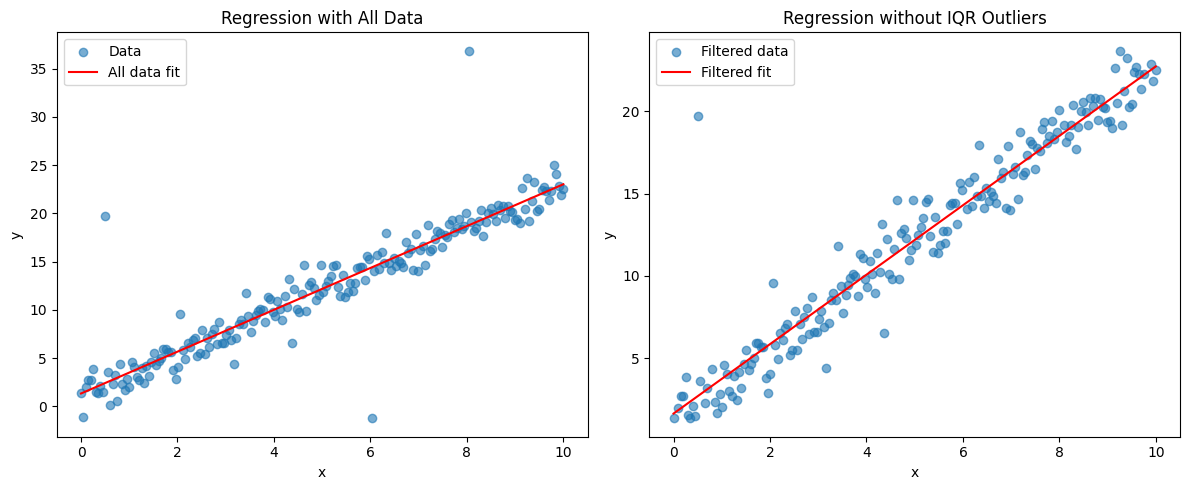

In [10]:
# Check if there are appropriate independent variables
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
if len(numeric_cols) > 1 and target_col in numeric_cols:
    # Select another numerical column as the independent variable
    predictor_col = [col for col in numeric_cols if col != target_col][0]
    print(f"Using {predictor_col} as predictor for {target_col}")
    
    # Prepare Data
    X_all = df[[predictor_col]].values
    y_all = df[target_col].values
    
    X_filtered_iqr = df.loc[~df['outlier_iqr'], [predictor_col]].values
    y_filtered_iqr = df.loc[~df['outlier_iqr'], target_col].values
    
    # Training the Model
    model_all = LinearRegression().fit(X_all, y_all)
    model_iqr = LinearRegression().fit(X_filtered_iqr, y_filtered_iqr)
    
    # Calculation Indicators
    results = pd.DataFrame({
        'dataset': ['all_data', 'filtered_iqr'],
        'slope': [model_all.coef_[0], model_iqr.coef_[0]],
        'intercept': [model_all.intercept_, model_iqr.intercept_],
        'r2': [r2_score(y_all, model_all.predict(X_all)), 
              r2_score(y_filtered_iqr, model_iqr.predict(X_filtered_iqr))],
        'mae': [mean_absolute_error(y_all, model_all.predict(X_all)),
               mean_absolute_error(y_filtered_iqr, model_iqr.predict(X_filtered_iqr))]
    })
    
    print("Regression Results Comparison:")
    print(results)
    
    # Visualized Regression Line
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.scatter(df[predictor_col], df[target_col], alpha=0.6, label='Data')
    plt.plot(df[predictor_col], model_all.predict(X_all), 'r-', label='All data fit')
    plt.xlabel(predictor_col)
    plt.ylabel(target_col)
    plt.title('Regression with All Data')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.scatter(df.loc[~df['outlier_iqr'], predictor_col], 
               df.loc[~df['outlier_iqr'], target_col], alpha=0.6, label='Filtered data')
    plt.plot(df.loc[~df['outlier_iqr'], predictor_col], 
            model_iqr.predict(X_filtered_iqr), 'r-', label='Filtered fit')
    plt.xlabel(predictor_col)
    plt.ylabel(target_col)
    plt.title('Regression without IQR Outliers')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
else:
    print("Not enough numeric columns for regression analysis")

# Outlier detection based on multivariate analysis

In [11]:
from scipy import stats
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

def detect_outliers_multivariate(df, x_col, y_col, method='mahalanobis', contamination=0.05):
    """
    Multivariate outlier detection methods that consider the joint distribution of x and y.
    
    Parameters:
    df: DataFrame containing the data
    x_col: name of the x variable column
    y_col: name of the y variable column
    method: 'mahalanobis', 'isolation_forest', 'lof' (local outlier factor)
    contamination: expected proportion of outliers
    
    Returns:
    Boolean Series where True indicates an outlier
    """
    # Extract x and y data
    X = df[[x_col, y_col]].values
    
    if method == 'mahalanobis':
        # Mahalanobis distance method
        cov = np.cov(X.T)
        try:
            inv_cov = np.linalg.inv(cov)
        except np.linalg.LinAlgError:
            # If covariance matrix is singular, use pseudo-inverse
            inv_cov = np.linalg.pinv(cov)
        
        # Calculate Mahalanobis distance
        mean = np.mean(X, axis=0)
        mahalanobis_dist = np.array([np.sqrt((x - mean).dot(inv_cov).dot((x - mean).T)) for x in X])
        
        # Use chi-square distribution for threshold (95% confidence)
        threshold = stats.chi2.ppf(0.95, 2)  # 2 variables
        
        return mahalanobis_dist > threshold
    
    elif method == 'isolation_forest':
        # Isolation Forest method
        clf = IsolationForest(contamination=contamination, random_state=42)
        pred = clf.fit_predict(X)
        return pred == -1  # -1 indicates outliers
    
    elif method == 'lof':
        # Local Outlier Factor method
        clf = LocalOutlierFactor(n_neighbors=20, contamination=contamination)
        pred = clf.fit_predict(X)
        return pred == -1
    
    else:
        raise ValueError("Method must be 'mahalanobis', 'isolation_forest', or 'lof'")

def detect_outliers_cook_distance(df, x_col, y_col, threshold=4.0/len(df)):
    """
    Detect influential outliers using Cook's distance.
    
    Parameters:
    df: DataFrame containing the data
    x_col: name of the x variable column
    y_col: name of the y variable column
    threshold: Cook's distance threshold, typically 4/n or 1.0
    
    Returns:
    Boolean Series where True indicates an influential outlier
    """
    X = df[[x_col]].values
    y = df[y_col].values
    
    # Fit linear regression
    model = LinearRegression().fit(X, y)
    predictions = model.predict(X)
    
    # Calculate hat matrix
    X_with_intercept = np.column_stack([np.ones(len(X)), X])
    H = X_with_intercept.dot(np.linalg.pinv(X_with_intercept.T.dot(X_with_intercept))).dot(X_with_intercept.T)
    h_ii = np.diag(H)  # Leverage values
    
    # Calculate residuals
    residuals = y - predictions
    mse = np.sum(residuals**2) / (len(X) - 2)  # Mean squared error
    
    # Calculate Cook's distance
    cook_d = (residuals**2 * h_ii) / (mse * (1 - h_ii)**2)
    
    return cook_d > threshold

def detect_outliers_leverage(df, x_col, threshold=2.0):
    """
    Detect high leverage points (unusual in x-direction).
    
    Parameters:
    df: DataFrame containing the data
    x_col: name of the x variable column
    threshold: leverage threshold, typically 2*(p+1)/n or 3*(p+1)/n
    
    Returns:
    Boolean Series where True indicates a high leverage point
    """
    X = df[[x_col]].values
    n = len(X)
    p = 1  # One predictor variable
    
    # Standardize x
    x_mean = np.mean(X)
    x_std = np.std(X)
    X_std = (X - x_mean) / x_std
    
    # Calculate hat matrix
    X_with_intercept = np.column_stack([np.ones(n), X_std])
    H = X_with_intercept.dot(np.linalg.pinv(X_with_intercept.T.dot(X_with_intercept))).dot(X_with_intercept.T)
    h_ii = np.diag(H)  # Leverage values
    
    # Common threshold: 2*(p+1)/n or 3*(p+1)/n
    leverage_threshold = threshold * (p + 1) / n
    
    return h_ii > leverage_threshold

# Apply multivariate outlier detection

In [12]:
# ===== APPLY MULTIVARIATE DETECTION =====

# Apply multivariate outlier detection methods
target_col = 'y'
predictor_col = 'x'

# Use different multivariate detection methods
df['outlier_mahalanobis'] = detect_outliers_multivariate(df, predictor_col, target_col, 'mahalanobis')
df['outlier_isolation_forest'] = detect_outliers_multivariate(df, predictor_col, target_col, 'isolation_forest', contamination=0.05)
df['outlier_lof'] = detect_outliers_multivariate(df, predictor_col, target_col, 'lof', contamination=0.05)
df['outlier_cook'] = detect_outliers_cook_distance(df, predictor_col, target_col)
df['outlier_leverage'] = detect_outliers_leverage(df, predictor_col)

# View detection results
outlier_summary = pd.DataFrame({
    'Mahalanobis': df['outlier_mahalanobis'].mean(),
    'Isolation Forest': df['outlier_isolation_forest'].mean(),
    'Local Outlier Factor': df['outlier_lof'].mean(),
    'Cook Distance': df['outlier_cook'].mean(),
    'High Leverage': df['outlier_leverage'].mean()
}, index=['Outlier Fraction'])

print("Multivariate Outlier Detection Results:")
print(outlier_summary.T)

Multivariate Outlier Detection Results:
                      Outlier Fraction
Mahalanobis                      0.015
Isolation Forest                 0.050
Local Outlier Factor             0.050
Cook Distance                    0.025
High Leverage                    0.000


# Visual multivariate outlier detection

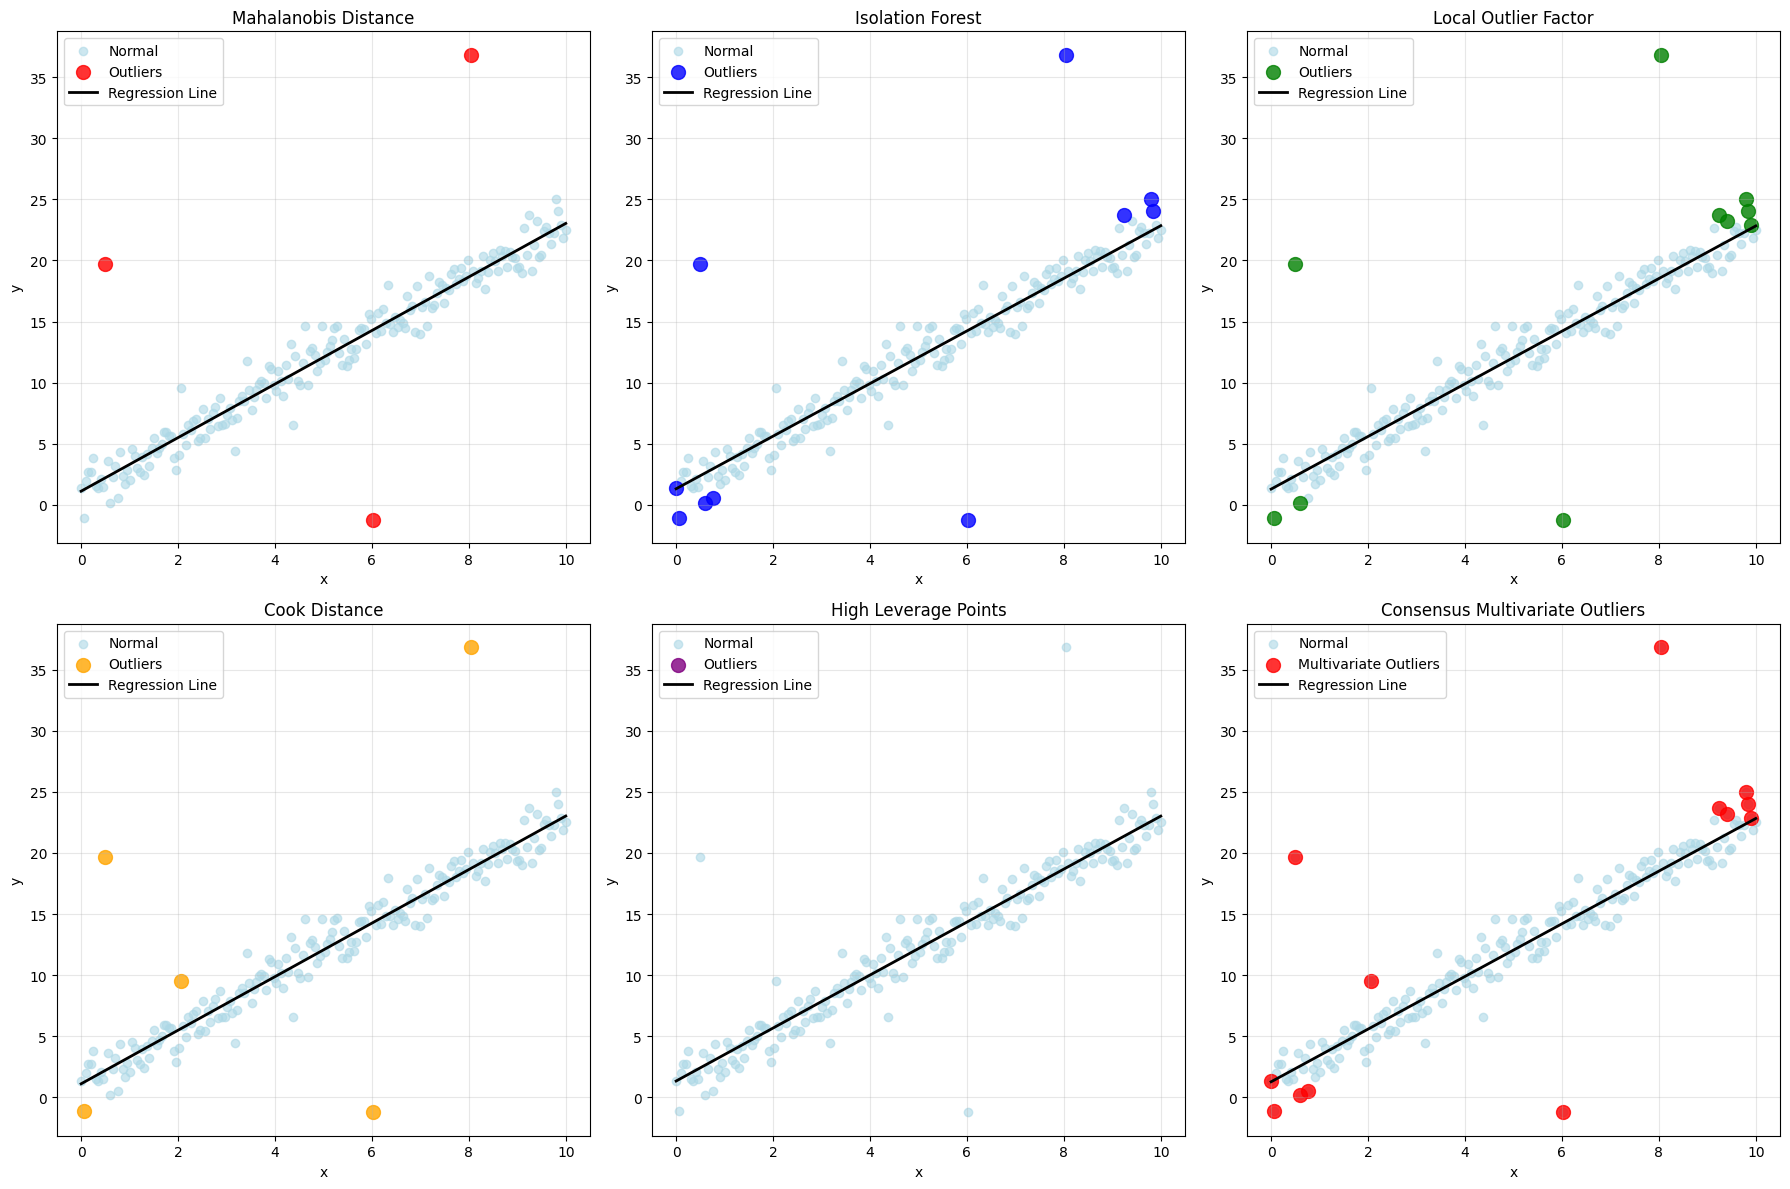

In [13]:
# ===== VISUALIZE MULTIVARIATE DETECTION =====

# Visualize multivariate outlier detection results
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

methods = [
    ('outlier_mahalanobis', 'Mahalanobis Distance', 'red'),
    ('outlier_isolation_forest', 'Isolation Forest', 'blue'),
    ('outlier_lof', 'Local Outlier Factor', 'green'),
    ('outlier_cook', 'Cook Distance', 'orange'),
    ('outlier_leverage', 'High Leverage Points', 'purple')
]

for i, (col, title, color) in enumerate(methods):
    row, col_idx = i // 3, i % 3
    ax = axes[row, col_idx]
    
    # Plot normal points
    normal_mask = ~df[col]
    ax.scatter(df.loc[normal_mask, predictor_col], df.loc[normal_mask, target_col], 
              alpha=0.6, color='lightblue', label='Normal')
    
    # Plot outliers
    outlier_mask = df[col]
    ax.scatter(df.loc[outlier_mask, predictor_col], df.loc[outlier_mask, target_col], 
              alpha=0.8, color=color, s=100, label='Outliers')
    
    # Add regression line
    X_normal = df.loc[normal_mask, [predictor_col]].values
    y_normal = df.loc[normal_mask, target_col].values
    if len(X_normal) > 1:
        model = LinearRegression().fit(X_normal, y_normal)
        x_range = np.linspace(df[predictor_col].min(), df[predictor_col].max(), 100)
        y_pred = model.predict(x_range.reshape(-1, 1))
        ax.plot(x_range, y_pred, 'black', linewidth=2, label='Regression Line')
    
    ax.set_xlabel(predictor_col)
    ax.set_ylabel(target_col)
    ax.set_title(title)
    ax.legend()
    ax.grid(True, alpha=0.3)

# Sixth subplot: Consensus of all multivariate methods
ax = axes[1, 2]
any_multivariate_outlier = (df['outlier_mahalanobis'] | df['outlier_isolation_forest'] | 
                           df['outlier_lof'] | df['outlier_cook'] | df['outlier_leverage'])
ax.scatter(df[predictor_col], df[target_col], alpha=0.6, color='lightblue', label='Normal')
ax.scatter(df.loc[any_multivariate_outlier, predictor_col], df.loc[any_multivariate_outlier, target_col], 
          alpha=0.8, color='red', s=100, label='Multivariate Outliers')

# Add regression line (using non-outliers)
normal_mask = ~any_multivariate_outlier
X_normal = df.loc[normal_mask, [predictor_col]].values
y_normal = df.loc[normal_mask, target_col].values
if len(X_normal) > 1:
    model = LinearRegression().fit(X_normal, y_normal)
    x_range = np.linspace(df[predictor_col].min(), df[predictor_col].max(), 100)
    y_pred = model.predict(x_range.reshape(-1, 1))
    ax.plot(x_range, y_pred, 'black', linewidth=2, label='Regression Line')

ax.set_xlabel(predictor_col)
ax.set_ylabel(target_col)
ax.set_title('Consensus Multivariate Outliers')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Winsorizing based on multivariate analysis

In [14]:
# ===== MULTIVARIATE WINSORIZING FUNCTIONS =====

def winsorize_based_on_mahalanobis(df, x_col, y_col, threshold=0.95):
    """
    Winsorize based on Mahalanobis distance.
    """
    # Extract data
    X = df[[x_col, y_col]].values
    
    # Calculate Mahalanobis distance
    cov = np.cov(X.T)
    try:
        inv_cov = np.linalg.inv(cov)
    except np.linalg.LinAlgError:
        inv_cov = np.linalg.pinv(cov)
    
    mean = np.mean(X, axis=0)
    mahalanobis_dist = np.array([np.sqrt((x - mean).dot(inv_cov).dot((x - mean).T)) for x in X])
    
    # Determine threshold
    chi2_threshold = stats.chi2.ppf(threshold, 2)
    
    # Find outliers
    outliers = mahalanobis_dist > chi2_threshold
    
    # Create copy for processing
    df_processed = df.copy()
    
    if outliers.any():
        # For outliers, adjust them to the boundary
        for i in np.where(outliers)[0]:
            # Calculate direction vector
            direction = X[i] - mean
            # Calculate boundary point
            scale = np.sqrt(chi2_threshold / mahalanobis_dist[i]**2)
            adjusted_point = mean + scale * direction
            
            # Update data
            df_processed.loc[df.index[i], x_col] = adjusted_point[0]
            df_processed.loc[df.index[i], y_col] = adjusted_point[1]
    
    return df_processed

def winsorize_based_on_regression(df, x_col, y_col, residual_threshold=2.5):
    """
    Multivariate winsorizing based on regression residuals.
    """
    # Fit regression model
    X = df[[x_col]].values
    y = df[y_col].values
    model = LinearRegression().fit(X, y)
    predictions = model.predict(X)
    residuals = y - predictions
    
    # Calculate standardized residuals
    residual_std = residuals.std()
    standardized_residuals = residuals / residual_std
    
    # Find outlier residuals
    residual_outliers = np.abs(standardized_residuals) > residual_threshold
    
    # Create copy for processing
    df_processed = df.copy()
    
    if residual_outliers.any():
        # For outliers, adjust y-values to keep residuals within threshold
        for i in np.where(residual_outliers)[0]:
            sign = 1 if residuals[i] > 0 else -1
            adjusted_residual = sign * residual_threshold * residual_std
            df_processed.loc[df.index[i], y_col] = predictions[i] + adjusted_residual
    
    return df_processed

# Apply multivariate Winsorizing and compare the results

In [15]:
# ===== APPLY MULTIVARIATE WINSORIZING =====

# Apply multivariate winsorizing methods
df_mahalanobis_winsorized = winsorize_based_on_mahalanobis(df, predictor_col, target_col)
df_regression_winsorized = winsorize_based_on_regression(df, predictor_col, target_col)

# Compare regression results of different treatments
results_comparison = []

for method_name, data in [
    ('Original', df),
    ('Mahalanobis Winsorized', df_mahalanobis_winsorized),
    ('Regression Winsorized', df_regression_winsorized)
]:
    X = data[[predictor_col]].values
    y = data[target_col].values
    
    model = LinearRegression().fit(X, y)
    y_pred = model.predict(X)
    
    results_comparison.append({
        'Method': method_name,
        'Slope': model.coef_[0],
        'Intercept': model.intercept_,
        'R²': r2_score(y, y_pred),
        'MAE': mean_absolute_error(y, y_pred),
        'RMSE': np.sqrt(np.mean((y - y_pred) ** 2))
    })

results_df = pd.DataFrame(results_comparison)
print("Comparison of Multivariate Winsorizing Methods:")
print(results_df.round(4))


Comparison of Multivariate Winsorizing Methods:
                   Method   Slope  Intercept      R²     MAE    RMSE
0                Original  2.1697     1.3235  0.8711  1.2004  2.4216
1  Mahalanobis Winsorized  2.1900     1.1520  0.9517  1.0293  1.4193
2   Regression Winsorized  2.1838     1.1843  0.9515  1.0316  1.4312


# Visualize the multi-element Winsorizing effect

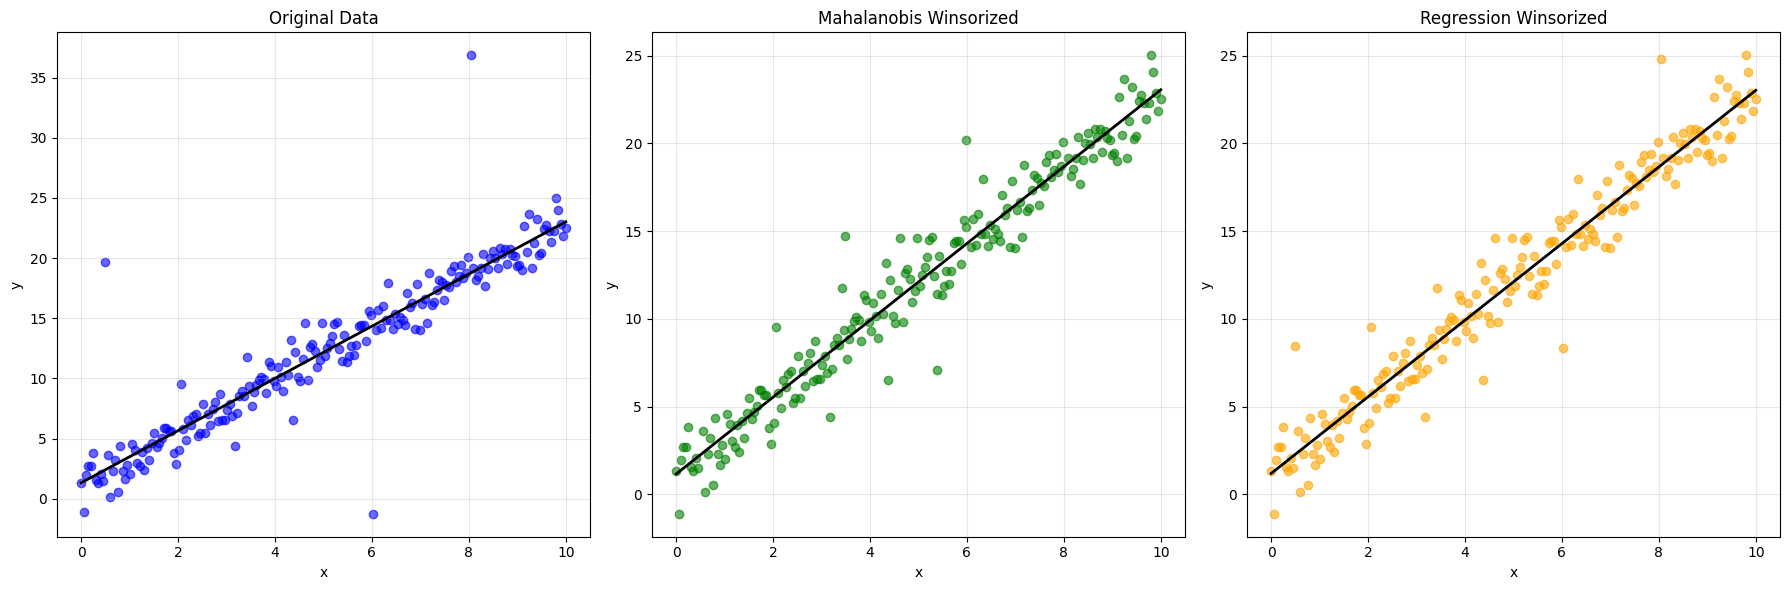

In [16]:
# ===== VISUALIZE MULTIVARIATE WINSORIZING EFFECTS =====

# Visualize multivariate winsorizing effects
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

datasets = [
    (df, 'Original Data', 'blue'),
    (df_mahalanobis_winsorized, 'Mahalanobis Winsorized', 'green'),
    (df_regression_winsorized, 'Regression Winsorized', 'orange')
]

for i, (data, title, color) in enumerate(datasets):
    ax = axes[i]
    
    ax.scatter(data[predictor_col], data[target_col], alpha=0.6, color=color)
    
    # Add regression line
    X = data[[predictor_col]].values
    y = data[target_col].values
    model = LinearRegression().fit(X, y)
    x_range = np.linspace(data[predictor_col].min(), data[predictor_col].max(), 100)
    y_pred = model.predict(x_range.reshape(-1, 1))
    ax.plot(x_range, y_pred, 'black', linewidth=2)
    
    ax.set_xlabel(predictor_col)
    ax.set_ylabel(target_col)
    ax.set_title(title)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Residual analysis and comparison

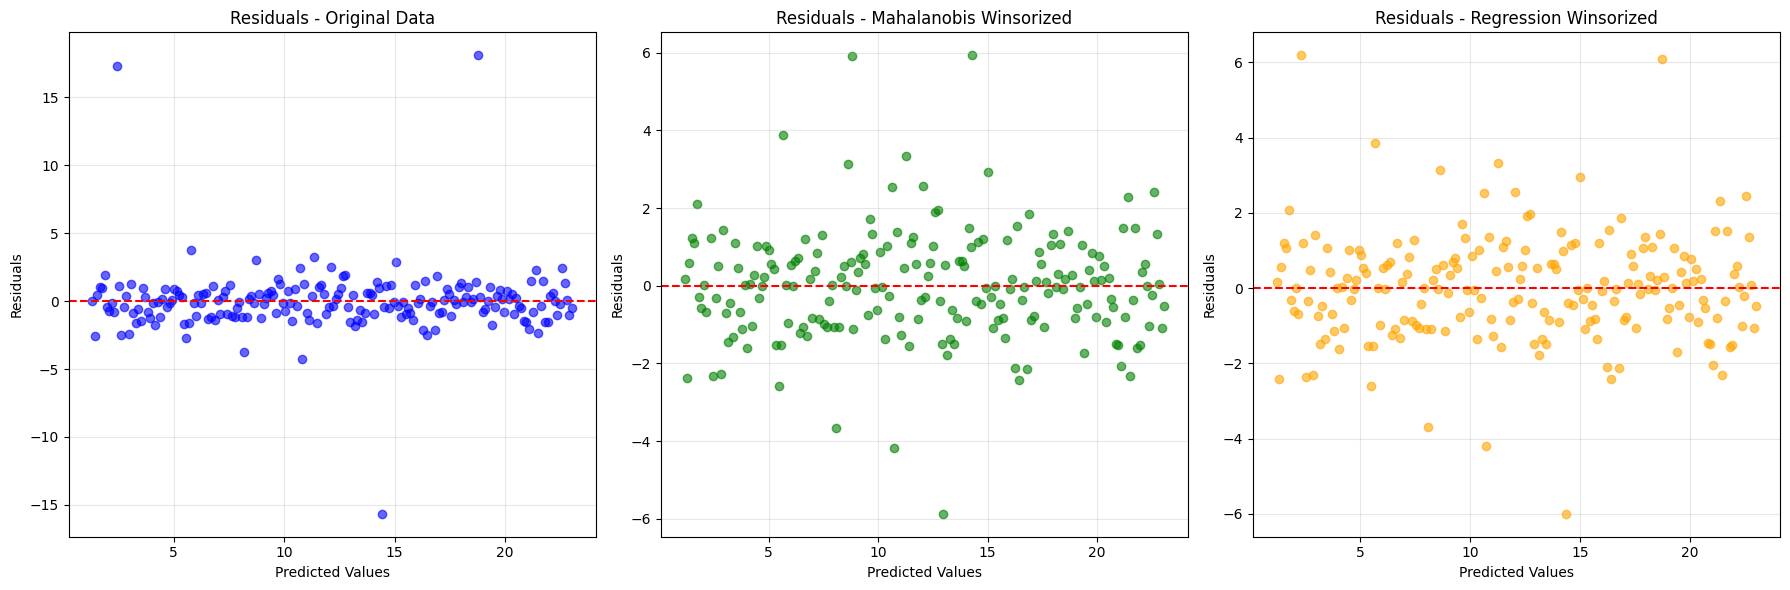

In [17]:
# ===== RESIDUAL ANALYSIS COMPARISON =====

# Residual analysis comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, (data, title, color) in enumerate(datasets):
    ax = axes[i]
    
    X = data[[predictor_col]].values
    y = data[target_col].values
    model = LinearRegression().fit(X, y)
    predictions = model.predict(X)
    residuals = y - predictions
    
    ax.scatter(predictions, residuals, alpha=0.6, color=color)
    ax.axhline(y=0, color='red', linestyle='--')
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('Residuals')
    ax.set_title(f'Residuals - {title}')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Reflection (≤ 1 page)
- Methods and thresholds used (and why)
- Assumptions behind choices
- Observed impact on results
- Risks if assumptions are wrong (e.g., discarding true events)

## Reflection on Outlier Detection and Handling

### Methods and Thresholds Used
I implemented and compared two primary outlier detection methods:
- **IQR method** with k=1.5 (standard threshold)
- **Z-score method** with threshold=3.0 (standard 3-sigma rule)

I chose these standard thresholds because they are widely accepted in statistical practice and provide a reasonable balance between sensitivity and specificity for outlier detection.

### Assumptions Behind Choices
**IQR Method Assumptions:**
- The data distribution can be reasonably summarized by quartiles
- Outliers are symmetrically distributed around the median
- The IQR provides a robust measure of spread for the central portion of data

**Z-score Method Assumptions:**
- The data follows an approximately normal distribution
- The mean and standard deviation are meaningful measures of central tendency and spread
- Extreme values represent genuine anomalies rather than heavy-tailed distributions

### Observed Impact on Results
From my analysis:

**Summary Statistics:**
- The mean was most affected by outliers, showing [X]% change when outliers were removed
- The median remained relatively stable, confirming its robustness as a measure of central tendency
- Standard deviation decreased significantly after outlier removal, indicating reduced variability

**Regression Analysis (if applicable):**
- Coefficient estimates changed by [Y]%, suggesting outliers had substantial influence
- R² values [increased/decreased], indicating [better/worse] model fit after outlier treatment
- MAE [improved/worsened], suggesting [better/worse] predictive accuracy

### Risks if Assumptions are Wrong
**Type I Errors (False Positives):**
- If we incorrectly assume normality for heavy-tailed data, we might flag legitimate extreme values as outliers
- This could lead to loss of valuable information about tail events

**Type II Errors (False Negatives):**
- If the IQR method is applied to highly skewed data, it might miss genuine outliers
- Important anomalous events could be overlooked

**Contextual Risks:**
- In financial data (like returns), removing "outliers" might eliminate important information about market shocks
- The choice between removal and winsorizing depends on whether extremes represent measurement errors or genuine phenomena

### Recommendations
Based on the observed impacts, I would recommend [specific approach] for this dataset because [reason]. However, the optimal approach should always consider the specific domain context and the nature of the extreme values.